## 1. Discretize of beam elements
Improving Timoshenko's Model Represented by Euler Angles.


### 1.1. Representation using quaternions
Since NSK uses quaternions to handle posture, we will model the quaternion representation in this program as well. Although there is an idea to convert Euler angles and quaternions for each calculation, we will use the direct quaternion method this time because it seems to be computationally expensive and there are already previous studies.

#### 1.1.1. Why quaternions?
Light computational cost. Gimbal lock does not occur.

|                 | Parameters | Memory | Handling | Notes                                                                   |
|:---------------:|:----------:|:------:|:--------:|:-----------------------------------------------------------------------:|
| Quaternion      | 4          | 0.5    | 1        | Has a good balance of abilities                                         |
| Eular           | 3          | 1      | 0        | The gradient per unit attitude change differs depending on the attitude |
| Rotation Matrix | 9          | 0      | 0.5      |                                                                         |

In [1]:
import numpy as np  # The next command is required: "pip install -U numpy"
import quaternion   # The next command is required: "pip install numpy-quaternion"


#### Simple Example

Make $q_0$ which means $60^o(= \frac{\pi}{3})$ degree rotation around the $z(=\begin{bmatrix} 0\\0\\1\end{bmatrix})$ axis.


In [2]:
q0 = quaternion.from_rotation_vector(np.array([0, 0, 1]) * np.pi / 3)
print(q0)

quaternion(0.866025403784439, 0, 0, 0.5)


$$
q_0 = \begin{bmatrix} \cos \frac{\theta}{2}\\ \sin \frac{\theta}{2} \begin{bmatrix} x\\y\\z \end{bmatrix} \end{bmatrix} = \begin{bmatrix} \cos \frac{60^0}{2}\\ 0 \\ 0 \\ \sin \frac{60^0}{2} \end{bmatrix} = \begin{bmatrix} \frac{\sqrt{3}}{2}\\ 0 \\ 0 \\ \frac{1}{2} \end{bmatrix}
$$

If we use this quaternion to calculate the rotation, we get this result.


In [3]:
print('Rotated x: ' + str(quaternion.rotate_vectors(q0, np.array([1, 0, 0]))))
print('Rotated y: ' + str(quaternion.rotate_vectors(q0, np.array([0, 1, 0]))))
print('Rotated z: ' + str(quaternion.rotate_vectors(q0, np.array([0, 0, 1]))))


Rotated x: [0.5       0.8660254 0.       ]
Rotated y: [-0.8660254  0.5        0.       ]
Rotated z: [0. 0. 1.]


$$
q_0 \otimes \begin{bmatrix} 1\\0\\0\end{bmatrix}=\begin{bmatrix} \frac{1}{2}\\\frac{\sqrt{3}}{2}\\0\end{bmatrix}, 
q_0 \otimes \begin{bmatrix} 0\\1\\0\end{bmatrix}=\begin{bmatrix} - \frac{\sqrt{3}}{2}\\ \frac{1}{2}\\0\end{bmatrix}, 
q_0 \otimes \begin{bmatrix} 0\\0\\1\end{bmatrix}=\begin{bmatrix} 0\\  0\\ 1 \end{bmatrix}
$$



![matrix1](tmpabe439_thumb.png)

http://what-when-how.com/the-finite-element-method/fem-for-frames-finite-element-method-part-1/


In [4]:
def Beam_Force0(x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty):
    q0_inv = q0.inverse()
    x1_ = quaternion.rotate_vectors(q0_inv, x1 - x0)

    dx = x1_ - np.array([l0, 0, 0])
    dq = q0_inv * q1 * 2
    
    Fx1 = kxx * dx[0]
    Fy1 = kyy * dx[1] - kyt * dq.z
    Fz1 = kyy * dx[2] + kyt * dq.y
    
    F1  = quaternion.rotate_vectors(q0, np.array([ Fx1, Fy1, Fz1]))
    
    Tx1 = ktx * dq.x
    Ty1 = kyt * dx[2] + kty * dq.y * 2
    Tz1 =-kyt * dx[1] + kty * dq.z * 2
    T1  = quaternion.rotate_vectors(q0, np.array([ Tx1, Ty1, Tz1]))
    
    Ty0 = kyt * dx[2] + kty * dq.y
    Tz0 =-kyt * dx[1] + kty * dq.z    
    T0  = quaternion.rotate_vectors(q0, np.array([-Tx1, Ty0, Tz0]))
    
    return -F1, T0, F1, T1

def Beam_Force1(x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty):
    q1_inv = q1.inverse()
    x0_ = quaternion.rotate_vectors(q1_inv, x0 - x1)

    dx = x0_ - np.array([-l0, 0, 0])
    dq = q1_inv * q0 * 2
    
    Fx0 = kxx * dx[0]
    Fy0 = kyy * dx[1] + kyt * dq.z
    Fz0 = kyy * dx[2] - kyt * dq.y
    
    F0  = quaternion.rotate_vectors(q0, np.array([ Fx0, Fy0, Fz0]))
    
    Tx0 = ktx * dq.x
    Ty0 =-kyt * dx[2] + kty * dq.y * 2
    Tz0 = kyt * dx[1] + kty * dq.z * 2
    T0  = quaternion.rotate_vectors(q0, np.array([ Tx0, Ty0, Tz0]))
    
    Ty1 =-kyt * dx[2] + kty * dq.y
    Tz1 = kyt * dx[1] + kty * dq.z    
    T1  = quaternion.rotate_vectors(q0, np.array([-Tx0, Ty1, Tz1]))
    
    return F0, T0, -F0, T1


![BEAM_Bend](BEAM_Bend.png)

In [5]:
r0 = 0.1
l0 = 1.0
E0 = 2e11
G0 = 8e10

A0 = np.pi * r0**2
I0 = np.pi / 4 * r0**4
J0 = np.pi / 2 * r0**4

kxx =  1 * E0 * A0 / l0
kyy = 12 * E0 * I0 / l0**3
kyt =  6 * E0 * I0 / l0**2
ktx =  1 * G0 * J0 / l0
kty =  2 * E0 * I0

x0 = np.array([0.0, 0.0, 0.0])
q0 = quaternion.from_float_array([1,0,0,0])
q1 = quaternion.from_float_array([1, 0, 0, 3.17e-05 / 2]).normalized()
x_unit = np.array([1, 0, 0])

x1 = x0 + l0 * (quaternion.rotate_vectors(q0, x_unit)) + np.array([0, 0.0212e-3, 0])

print(Beam_Force0( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))
print(Beam_Force1( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))


(array([   -0.        , -1008.45124218,    -0.        ]), array([    0.        ,     0.        , -1002.16805662]), array([   0.        , 1008.45124218,    0.        ]), array([ 0.        ,  0.        , -6.28318556]))
(array([   -1.06559684, -1008.45124092,     0.        ]), array([    0.        ,     0.        , -1002.16805599]), array([   1.06559684, 1008.45124092,   -0.        ]), array([ 0.        ,  0.        , -6.28318493]))


![BEAM_Twist](BEAM_Twist.png)

In [6]:
x0 = np.array([0.0, 0.0, 0.0])
q0 = quaternion.from_float_array([1,0,0,0])
q1 = quaternion.from_float_array([1, 0.000796 / 2, 0, 0]).normalized()
x_unit = np.array([1, 0, 0])

x1 = x0 + l0 * (quaternion.rotate_vectors(q0, x_unit))

print(Beam_Force0( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))
print(Beam_Force1( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))


(array([-0., -0., -0.]), array([-10002.83021679,      0.        ,      0.        ]), array([0., 0., 0.]), array([10002.83021679,     0.        ,     0.        ]))
(array([0., 0., 0.]), array([-10002.83021679,      0.        ,      0.        ]), array([-0., -0., -0.]), array([10002.83021679,     0.        ,     0.        ]))


![BEAM_pull](BEAM_pull.png)

In [7]:
x0 = np.array([0.0, 0.0, 0.0])
q0 = quaternion.from_float_array([1,0,0,0])
q1 = quaternion.from_float_array([1, 0, 0, 0]).normalized()
x_unit = np.array([1, 0, 0])

x1 = x0 + l0 * (quaternion.rotate_vectors(q0, x_unit)) + np.array([0.000159e-3, 0, 0])

print(Beam_Force0( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))
print(Beam_Force1( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))


(array([-999.02646419,   -0.        ,   -0.        ]), array([0., 0., 0.]), array([999.02646419,   0.        ,   0.        ]), array([0., 0., 0.]))
(array([-999.02646419,    0.        ,    0.        ]), array([0., 0., 0.]), array([999.02646419,  -0.        ,  -0.        ]), array([0., 0., 0.]))


In [8]:
x0 = np.random.randn(3)
q0 = quaternion.from_float_array(np.random.randn(4)).normalized()
dq = quaternion.from_float_array(np.append(1, np.random.randn(3) * 1e-8)).normalized()
q1 = q0 * dq
x_unit = np.array([1, 0, 0])

x1 = x0 + l0 * (quaternion.rotate_vectors(q0, x_unit)) + np.random.randn(3) * 1e-6

print(Beam_Force0( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))
print(Beam_Force1( x0, q0, x1, q1, l0, kxx, kyy, kyt, ktx, kty))


(array([831.30817861, 411.81270597, 441.149526  ]), array([ 20.36067311,  58.31543364, -92.99558012]), array([-831.30817861, -411.81270597, -441.149526  ]), array([ 20.07797735,  58.21258835, -91.98637296]))
(array([831.30802894, 411.81257996, 441.14941706]), array([ 20.36067414,  58.31543303, -92.99558082]), array([-831.30802894, -411.81257996, -441.14941706]), array([ 20.07797837,  58.21258774, -91.98637366]))


a

$$
\begin{align}
\theta_z(x) &= ax^2 + bx \\\\
\theta_z(0) &= 0 \\\\
\theta_z(l_0) &= al_0^2 + bl_0 = \Delta \theta_z \\\\
\int_{0}^{l_0} \theta_z(x) dx &= \int_{0}^{l_0} (ax^2 + bx) dx　\\\\
&= \left[\frac{1}{3}ax^3 + \frac{1}{2}bx^2 \right]^{l_0}_0　\\\\
&= \frac{l_0^3}{3}a + \frac{l_0^2}{2}b　= \Delta y \\\\
\end{align}
$$

aaa

$$
\begin{align}
\begin{bmatrix} \frac{l_0^3}{3} & \frac{l_0^2}{2} \\ l_0^2 & l_0 \end{bmatrix} \begin{bmatrix} a \\ b \end{bmatrix} &= \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
\begin{bmatrix} a \\ b \end{bmatrix} &= \begin{bmatrix} \frac{l_0^3}{3} & \frac{l_0^2}{2} \\ l_0^2 & l_0 \end{bmatrix}^{-1} \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
&= \begin{bmatrix} -\frac{6}{l_0^3} & \frac{3}{l_0^2} \\ \frac{6}{l_0^2} & -\frac{2}{l_0} \end{bmatrix} \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
\end{align}
$$

bbbb

$$
\begin{align}
0 \leq &s \leq 1 \\\\
y(s) &= \frac{a}{3}(l_0 s)^3 + \frac{b}{2}(l_0 s)^2 \\\\
\theta_z(s) &= a(l_0 s)^2 + b(l_0 s) \\\\
\end{align}
$$

同様にzについても解くと，

$$
\begin{align}
\begin{bmatrix} \frac{l_0^3}{3} & \frac{l_0^2}{2} \\ l_0^2 & l_0 \end{bmatrix} \begin{bmatrix} c \\ d \end{bmatrix} &= \begin{bmatrix} -\Delta z \\ \Delta \theta_y \end{bmatrix} \\\\
\begin{bmatrix} c \\ d \end{bmatrix} &= \begin{bmatrix} -\frac{l_0^3}{3} & -\frac{l_0^2}{2} \\ l_0^2 & l_0 \end{bmatrix}^{-1} \begin{bmatrix} \Delta z \\ \Delta \theta_y \end{bmatrix} \\\\
&= \begin{bmatrix} \frac{6}{l_0^3} & \frac{3}{l_0^2} \\ -\frac{6}{l_0^2} & -\frac{2}{l_0} \end{bmatrix} \begin{bmatrix} \Delta z \\ \Delta \theta_y \end{bmatrix} \\\\
\end{align}
$$

$$
\begin{align}
0 \leq &s \leq 1 \\\\
z(s) &= -\frac{c}{3}(l_0 s)^3 - \frac{d}{2}(l_0 s)^2 \\\\
\theta_y(s) &= c(l_0 s)^2 + d(l_0 s) \\\\
\end{align}
$$

また，x についても考えると

$$
\begin{align}
0 \leq &s \leq 1 \\\\
x(s) &= (l_0 + \Delta x) s \\\\
\theta_x(s) &= \Delta \theta_x s \\\\
\end{align}
$$



In [9]:
def Beam_Matrix(l0):
    l0_1 = 1 / l0
    l0_2 = 1 / l0 / l0
    l0_3 = 1 / l0 / l0 / l0
    
    ab_inv0 = np.array([[-6 * l0_3, 3 * l0_2], [ 6 * l0_2, -2 * l0_1]])
    cd_inv0 = np.array([[ 6 * l0_3, 3 * l0_2], [-6 * l0_2, -2 * l0_1]])

    return ab_inv0, cd_inv0


def Beam_Coefficient(x0, q0, x1, q1, l0, ab_inv0, cd_inv0):
    q0_inv = q0.inverse()
    x1_ = quaternion.rotate_vectors(q0_inv, x1 - x0)

    dx = x1_ - np.array([l0, 0, 0])
    dq = q0_inv * q1 * 2
    
    ab0 = ab_inv0 @ np.array([dx[1], dq.z])
    cd0 = cd_inv0 @ np.array([dx[2], dq.y])
    
    dx0  = l0 + dx[0]
    dqx0 = dq.x
    
    return ab0, cd0, dx0, dqx0

# 
def Beam_Displacement(x0, q0, l0, s, ab0, cd0, dx0, dqx0):
    
    ls  = l0 * s
    ls2 = ls * ls
    ls3 = ls2 * ls
    
    x_ = dx0 * s
    y_ = ab0[0] / 3 * ls3 + ab0[1] / 2 * ls2
    z_ =-cd0[0] / 3 * ls3 - cd0[1] / 2 * ls2
    
    tx_ = dqx0 * s
    ty_ = cd0[0] * ls2 + cd0[1] * ls
    tz_ = ab0[0] * ls2 + ab0[1] * ls
    
    xs = x0 + quaternion.rotate_vectors(q0, np.array([x_,y_,z_]))
    qs = q0 * quaternion.from_float_array([1, tx_/2, ty_/2, tz_/2]).normalized()
    
    return xs, qs


In [11]:
ab_inv0, cd_inv0 = Beam_Matrix(l0)
ab0, cd0, dx0, dqx0 = Beam_Coefficient(x0, q0, x1, q1, l0, ab_inv0, cd_inv0)
xs, qs = Beam_Displacement(x0, q0, l0, 0.0, ab0, cd0, dx0, dqx0)

print(xs, qs)
print(x0, q0)

xs, qs = Beam_Displacement(x0, q0, l0, 1.0, ab0, cd0, dx0, dqx0)

print(xs, qs)
print(x1, q1)


[-0.15427106 -0.35680599  2.44877879] quaternion(0.860670265910469, 0.306312127921109, -0.153712686203362, 0.376552763588572)
[-0.15427106 -0.35680599  2.44877879] quaternion(0.860670265910469, 0.306312127921109, -0.153712686203362, 0.376552763588572)
[0.51488883 0.19720211 2.94405624] quaternion(0.860670260679644, 0.306312126770094, -0.153712680617845, 0.376552778760816)
[0.51488883 0.19720211 2.94405624] quaternion(0.860670260679644, 0.306312126770094, -0.153712680617845, 0.376552778760816)


In [12]:
ab1, cd1, dx1, dqx1 = Beam_Coefficient(x1, q1, x0, q0, l0, ab_inv0, cd_inv0)
xs, qs = Beam_Displacement(x1, q1, l0, 0.0, ab1, cd1, dx1, dqx1)

print(xs, qs)
print(x1, q1)

xs, qs = Beam_Displacement(x1, q1, l0, 1.0, ab1, cd1, dx1, dqx1)

print(xs, qs)
print(x0, q0)


[0.51488883 0.19720211 2.94405624] quaternion(0.860670260679644, 0.306312126770094, -0.153712680617845, 0.376552778760816)
[0.51488883 0.19720211 2.94405624] quaternion(0.860670260679644, 0.306312126770094, -0.153712680617845, 0.376552778760816)
[-0.15427106 -0.35680599  2.44877879] quaternion(0.860670265910469, 0.306312127921109, -0.153712686203362, 0.376552763588572)
[-0.15427106 -0.35680599  2.44877879] quaternion(0.860670265910469, 0.306312127921109, -0.153712686203362, 0.376552763588572)


In [14]:
n0 = 100
s_array = np.linspace(0, 1, n0)
x_array = np.zeros([3, n0])
q_array = np.zeros([3, n0])
x_array_= np.zeros([3, n0])

for i0 in range(n0):
    xs, qs = Beam_Displacement(x0, q0, l0, s_array[i0], ab0, cd0, dx0, dqx0)
    x_array[:,i0] = xs
    q_array[:,i0] = quaternion.rotate_vectors(qs, x_unit)
    
    xs, qs = Beam_Displacement(x1, q1, l0, 1 - s_array[i0], ab1, cd1, dx1, dqx1)
    x_array_[:,i0] = xs
    
u_array = x_array[:, 2:] - x_array[:, :-2]
u_array = u_array / np.sqrt(np.square(u_array).sum(0))


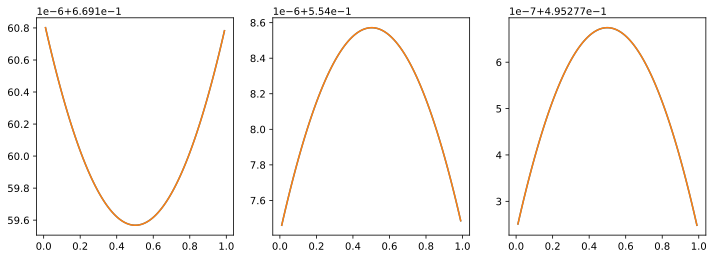

In [15]:
%config InlineBackend.figure_format = "svg"
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
for i in range(3):
    ax[i].plot(s_array[1:-1], u_array[i,:], s_array[1:-1], q_array[i,1:-1])


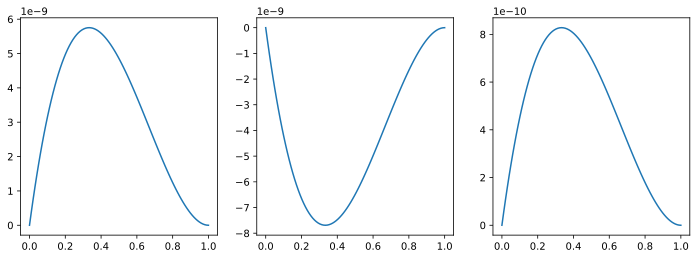

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
for i in range(3):
    ax[i].plot(s_array, x_array[i,:] - x_array_[i,:])




#### 1.1.2. Previous research

非線形3次元ビームの定式化では、ビームのデ・フォームされた形状は、ビームの変形軸と断面の回転によって記述される。したがって、ビームの構成空間は、（i）変形軸の位置ベクトルの線形空間と、（ii）断面の回転の非線形空間とからなり、非線形多様体となる。空間回転の非線形性は特別な扱いを必要とするため、3次元ビームの研究は興味深く、挑戦的なものとなっています。
In non-linear three-dimensional beam formulations, the de- formed geometry of the beam is described by the deformed axis of the beam and by the rotation of the cross-sections. The configu- ration space of the beam thus consists of (i) the linear space of the position vector of the deformed axis, and (ii) the non-linear space of rotations of cross-sections, and is thus a non-linear manifold. The non-linearity of spatial rotations requires a special treatment, which makes the study of three-dimensional beams interesting and challenging.


梁の弾性問題には中心軸からの変位と回転の評価が非常重要です。しかし、実際には回転が重要なのではなく、曲げおよびそれによって発生する歪みが重要なのであって、全体が一様に回転している場合には歪みは発生しません。一方で、ボールねじのねじ軸を弾性体として扱う場合には、離散化するべき部材の形状はは太さに対して長さが十分に短く、一次近似で十分な場合がほとんどです。そこで今回のモデルは変形が十分小さい仮定のもと、両端のノードは任意の変位および姿勢をもつものとして、その場合に発生するバネ反力について定式化する。全体の回転についてはクォータニオンに任せ、微小回転についてはクォータニオンを用いて近似を行う。



# ボツアイデア

$
\Delta \vec{x_R} = q_{0}^{\ast} \otimes (\vec{x_R} - \vec{x_0}) - \frac{l}{2} \begin{bmatrix} 1 \\ 0 \\ 0 \\ \end{bmatrix} \approx \begin{bmatrix} \Delta x_R \\ \Delta y_R \\ \Delta z_R \end{bmatrix} , \Delta q_R = q_0^{\ast} \otimes q_R \approx \begin{bmatrix} 1 \\ \Delta \theta_{xR} / 2 \\ \Delta \theta_{yR} / 2 \\ \Delta \theta_{zR} / 2 \\ \end{bmatrix} \\\\
\Delta \vec{x_L} = q_{0}^{\ast} \otimes (\vec{x_L} - \vec{x_0}) + \frac{l}{2} \begin{bmatrix} 1 \\ 0 \\ 0 \\ \end{bmatrix} \approx \begin{bmatrix} \Delta x_L \\ \Delta y_L \\ \Delta z_L \end{bmatrix} , \Delta q_L = q_0^{\ast} \otimes q_L \approx \begin{bmatrix} 1 \\ \Delta \theta_{xL} / 2 \\ \Delta \theta_{yL} / 2 \\ \Delta \theta_{zL} / 2 \\ \end{bmatrix} \\\\
$



$
 \begin{bmatrix} F_{xR} \\ F_{yR} \\ F_{zR} \\ T_{xR} \\ T_{yR} \\ T_{zR} \\ \end{bmatrix} =
-\begin{bmatrix} F_{x0} \\ F_{y0} \\ F_{z0} \\ T_{x0} \\ T_{y0} \\ T_{z0} \\ \end{bmatrix} =
\begin{bmatrix} 
\frac{2EA}{l} & 0 & 0 & 0 & 0 & 0 \\
0 & \frac{96EI}{l^3} & 0 & 0 & 0 & \frac{24EI}{l^2} \\
0 & 0 & \frac{96EI}{l^3} & 0 & -\frac{24EI}{l^2} & 0 \\
0 & 0 & 0 & \frac{2GJ}{l} & 0 & 0 \\ 
0 & 0 & -\frac{24EI}{l^2} & 0 & \frac{8EI}{l} & 0 \\
0 & \frac{24EI}{l^2} & 0 & 0 & 0 & \frac{8EI}{l} \\
\end{bmatrix}
\begin{bmatrix} \Delta x_R \\ \Delta y_R \\ \Delta z_R \\ \Delta \theta_{xR} \\ \Delta \theta_{yR} \\ \Delta \theta_{zR} \\ \end{bmatrix} \\\\
$


$
\begin{align}\begin{cases}
\Delta x_R &= -\Delta x_L \\
\Delta \theta_{xR} &= -\Delta \theta_{xL} \\
\end{cases}\end{align}
$

$
\begin{align}\begin{cases}
4 \Delta y_R + l \Delta \theta_{zR} &=  4 \Delta y_L - l \Delta \theta_{zL} \\
3 \Delta y_R - l \Delta \theta_{zR} &=  3 \Delta y_L - l \Delta \theta_{zL} \\
\end{cases}\end{align}
$

$
\begin{align}\begin{cases}
4 \Delta z_R - l \Delta \theta_{yR} &= -4 \Delta z_L - l \Delta \theta_{yL} \\
3 \Delta z_R - l \Delta \theta_{yR} &=  3 \Delta z_L + l \Delta \theta_{yL} \\
\end{cases}\end{align}
$


q0 = quaternion.from_rotation_vector(np.array([1, 0, 0]) * 0.001)
q1 = quaternion.from_rotation_vector(np.array([0, 1, 0]) * 0.001)
q2 = quaternion.from_rotation_vector(np.array([0, 0, 1]) *-0.001)

print(q2 * q1 * q0)


q0 / q1


eye3 = np.eye(3)
quaternion.rotate_vectors(q0.inverse(), eye3)

Two types of modeling of beams by quaternions have been presented by the same laboratory.

|Kinematically Exact Beam Finite Elements Based on Quaternion Algebra (2014)|A consistent strain-based beam element with quaternion representation of rotations (2020)|
|:---:|:---:|
|![1‗2014](1_2014.png)|![1_2020](1_2020.png)|
|Eva Zupan, Miran Saje, **Dejan Zupan**|Damjan Loli, **Dejan Zupan**, Miha Brojan|
|University of Ljubljana|University of Ljubljana|
|Simple|Complex|
|displacement-based|strain-based|
|12 DOFs per element|26 DOFs per element|
|**to small shear deformations**|to larger shear deformations|

In order to deal with the deformation of the ballscrew this time, we do not need to consider "larger shear deformations", so I will deal with the **2014 model**.




#### Beam Model

input:

$
p=0...N+1,
\chi_p,
r_g(\chi_p),
\hat{q}(\chi_p)
$

parameter:

$
\mathscr C _N = \begin{bmatrix} EA_1 & 0 & 0 \\ 0 & GA_2 & 0 \\ 0 & 0 & GA_3 \end{bmatrix} \gamma _G(\chi _k),
\mathscr C _M = \begin{bmatrix} GJ_1 & 0 & 0 \\ 0 & EJ_2 & 0 \\ 0 & 0 & EJ_3 \end{bmatrix} \kappa _G(\chi _k)
$

local variable:

$
k=1...N,
n_g(\chi_k),
\hat{m}_g(\chi_k),
N_g(\frac{L}{2}),
M_g(\frac{L}{2})
$

$
r'_g(\chi) = \sum_{p=0}^{N+1} L'(\chi_p)r_g(\chi_p)
$

$
\gamma _G(\chi _k) = \left[ \hat{q}^*(\chi_k) \circ \hat r' _g(\chi _k) \circ \hat{q}(\chi_k) \right] _{\mathbb{R}^3},
\kappa _G(\chi _k) = 2 \left[ \hat{q}^*(\chi_k) \circ \hat{q}'(\chi_k) \right] _{\mathbb{R}^3}
$

output (k):

$
\left[\hat{q}(\chi_k) \circ \mathscr {\hat C} _N \circ \hat{q}^*(\chi_k) \right]' _{\mathbb{R}^3} + n_g(\chi_k) = 0
$

$
\left( \hat{q}(\chi_k) \circ \mathscr {\hat C} _M \circ \hat{q}^*(\chi_k) \right)' + \hat{m}_g(\chi_k) - N_g(\frac{L}{2})\times r'_g(\chi_k)  + \int_{\chi_k}^{L / 2} n_g(\chi) \,d\chi \times r'_g(\chi_k) = 0
$

output:

$
F_g(0) + N_g(\frac{L}{2}) + \int_{0}^{L / 2} n_g(\chi) \,d\chi = 0
$

$
P_g(0) + M_g(\frac{L}{2}) - N_g(\frac{L}{2}) \times \left( r_g(\frac{L}{2}) - r_g(0) \right) - \int_{0}^{L / 2} n_g(\chi) \times \left(r_g(\chi) - r_g(0) \right) \,d\chi + \int_{0}^{L / 2} m_g(\chi) \,d\chi = 0
$

$
F_g(L) - N_g(\frac{L}{2}) + \int_{L / 2}^{L} n_g(\chi) \,d\chi = 0
$

$
P_g(L) - M_g(\frac{L}{2}) - N_g(\frac{L}{2}) \times \left( r_g(L) - r_g(\frac{L}{2}) \right) + \int_{L / 2}^{L} n_g(\chi) \times \left(r_g(L) - r_g(\chi) \right) \,d\chi + \int_{L / 2}^{L} m_g(\chi) \,d\chi = 0
$


In [ ]:
def CN_CM_Rectangle(E, G, L, t, h):
    
    A1 = t * h
    A2 = L * t
    A3 = h * L
    
    CN = np.array([E * A1, G * A2, G * A3])

    J_Rectangle = lambda b, d: b * d * (b*b + d*d) / 12
    
    J1 = J_Rectangle(t, h)
    J2 = J_Rectangle(L, t)
    J3 = J_Rectangle(h, L)
    
    CM = np.array([G * J1, E * J2, E * J3])
    
    return CN, CM


In [ ]:
E = 1e7
G = 1e13
L = 1
t = 0.1
h = 0.1 # 0.1~10

CN, CM = CN_CM_Rectangle(E, G, L, t, h)

print(CN, CM)


#### hoge

$\delta \hat \kappa _G = 2 \delta \hat q ^* \circ \hat q' + 2 \hat q ^* \circ \delta \hat q'$

In [ ]:
def calc_delta_kappaG(q0, q1):
    return 1

$
y ^{[n + 1]} = y ^{[n]} + \delta y
$

$
r_g ^{p [n + 1]} = r_g ^{p [n]} + \delta r ^p _g \qquad(p =0,..., N+1)
$

$
N_g(\chi) = N_g(\frac{L}{2}) + \int_{\chi}^{L / 2} n_g \,d\xi
$

$
M_g(\chi) = M_g(\frac{L}{2}) + \int_{\chi}^{L / 2} m_g \,d\xi - \int_{\chi}^{L / 2} N_g \times r'_g \,d\xi
$

$
r'_g(\chi_k) \approx \frac{r_g(\chi_{k + 1}) - r_g(\chi_{k - 1})}{2} \frac{L}{N + 1} \\\\
r'_g(\chi_k) \approx \frac{r_g(\chi_{k + 1}) - r_g(\chi_{k - 1})}{2} \frac{L}{N + 1}
$




a

$$
\begin{align}
\theta_z(x) &= ax^2 + bx \\\\
\theta_z(0) &= 0 \\\\
\theta_z(-l_0) &= al_0^2 - bl_0 = \Delta \theta_z \\\\
\int_{-l_0}^{0} \theta_z(x) dx &= \int_{-l_0}^{0} (ax^2 + bx) dx　\\\\
&= \left[\frac{1}{3}ax^3 + \frac{1}{2}bx^2 \right]_{-l_0}^{0}　\\\\
&= \frac{l_0^3}{3}a - \frac{l_0^2}{2}b　= - \Delta y \\\\
\end{align}
$$

aaa

$$
\begin{align}
\begin{bmatrix} -\frac{l_0^3}{3} & \frac{l_0^2}{2} \\ l_0^2 & -l_0 \end{bmatrix} \begin{bmatrix} a \\ b \end{bmatrix} &= \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
\begin{bmatrix} a \\ b \end{bmatrix} &= \begin{bmatrix} -\frac{l_0^3}{3} & \frac{l_0^2}{2} \\ l_0^2 & -l_0 \end{bmatrix}^{-1} \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
&= \begin{bmatrix} \frac{6}{l_0^3} & \frac{3}{l_0^2} \\ \frac{6}{l_0^2} & \frac{2}{l_0} \end{bmatrix} \begin{bmatrix} \Delta y \\ \Delta \theta_z \end{bmatrix} \\\\
\end{align}
$$

同様にzについても解くと，

$$
\begin{align}
\begin{bmatrix} \frac{l_0^3}{3} & -\frac{l_0^2}{2} \\ l_0^2 & -l_0 \end{bmatrix} \begin{bmatrix} c \\ d \end{bmatrix} &= \begin{bmatrix} \Delta z \\ \Delta \theta_y \end{bmatrix} \\\\
\begin{bmatrix} c \\ d \end{bmatrix} &= \begin{bmatrix} -\frac{6}{l_0^3} & \frac{3}{l_0^2} \\ -\frac{6}{l_0^2} & \frac{2}{l_0} \end{bmatrix} \begin{bmatrix} \Delta z \\ \Delta \theta_y \end{bmatrix} \\\\
\end{align}
$$


def Beam_Matrix1(l0):
    l0_1 = 1 / l0
    l0_2 = 1 / l0 / l0
    l0_3 = 1 / l0 / l0 / l0
    
    ab_inv1 = np.array([[ 6 * l0_3, 3 * l0_2], [ 6 * l0_2, 2 * l0_1]])
    cd_inv1 = np.array([[-6 * l0_3, 3 * l0_2], [-6 * l0_2, 2 * l0_1]])

    return ab_inv1, cd_inv1


def Beam_Coefficient1(x0, q0, x1, q1, l0, ab_inv1, cd_inv1):
    q1_inv = q1.inverse()
    x0_ = quaternion.rotate_vectors(q1_inv, x0 - x1)

    dx = x0_ - np.array([-l0, 0, 0])
    dq = q1_inv * q0 * 2
    
    ab1 = ab_inv1 @ np.array([dx[1], dq.z])
    cd1 = cd_inv1 @ np.array([dx[2], dq.y])
    
    dx1  = l0 - dx[0]
    dqx1 = dq.x
    
    return ab1, cd1, dx1, dqx1

# 
def Beam_Displacement1(x1, q1, l0, t, ab1, cd1, dx1, dqx1):
    
    s = 1 - t
    ls  = l0 * s
    ls2 = ls * ls
    ls3 = ls2 * ls
    
    x_ =-dx1 * s
    y_ = ab1[0] / 3 * ls3 + ab1[1] / 2 * ls2
    z_ =-cd1[0] / 3 * ls3 - cd1[1] / 2 * ls2
    
    tx_ =-dqx1 * s
    ty_ = cd1[0] * ls2 + cd1[1] * ls
    tz_ = ab1[0] * ls2 + ab1[1] * ls
    
    xs = x1 + quaternion.rotate_vectors(q1, np.array([x_,y_,z_]))
    qs = q1 * quaternion.from_float_array([1, tx_/2, ty_/2, tz_/2]).normalized()
    
    return xs, qs


ab_inv1, cd_inv1 = Beam_Matrix1(l0)
ab1, cd1, dx1, dqx1 = Beam_Coefficient1(x0, q0, x1, q1, l0, ab_inv1, cd_inv1)
xs, qs = Beam_Displacement1(x1, q1, l0, 0.0, ab1, cd1, dx1, dqx1)

print(xs, qs)
print(x0, q0)

